# IBM Applied Data Science Capstone Project
## By Tirth Jignesh Raval
## Week 3 Part 3

Explore and cluster the neighborhoods in Toronto.

## 1. Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd
import folium
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
!conda install -c conda-forge lxml --yes
import requests
import lxml.html as lh
from sklearn.cluster import KMeans
print("Libraries imported.")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

## 2. Scrap data from Wikipedia page into a DataFrame (Based on Previous Part)

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
r = requests.get(url)

#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print ('%d:"%s"'%(i,name))
    col.append((name,[]))

size_of_col = 3
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    if len(T)!=size_of_col:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
        
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df = df.replace(r'\n','', regex=True) 
df.columns = ['PostalCode', 'Borough', 'Neighborhood']
df.drop(df.tail(1).index,inplace=True)

df = df[df.Borough != "Not assigned"].reset_index(drop=True)

df = df.replace(r'/',', ', regex=True) 

for index, row in df.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
df.head()

1:"Postal Code
"
2:"Borough
"
3:"Neighborhood
"


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## 3. Defining the new Dataframe Format

In [3]:
df["Latitude"] = ""
df["Longitude"] = ""
df.shape

(103, 5)

In [4]:
# Cleaning the neighborhood with multiple values ( Selecting the first one)
df["Neighborhood"] = df["Neighborhood"].str.split(",", n = 1, expand = True) 
df["Neighborhood"] = df["Neighborhood"].str.split("-", n = 1, expand = True) 
df["Neighborhood"].head(5)

0           Parkwoods
1    Victoria Village
2         Regent Park
3      Lawrence Manor
4        Queen's Park
Name: Neighborhood, dtype: object

In [5]:
df.head(50)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,,
1,M4A,North York,Victoria Village,,
2,M5A,Downtown Toronto,Regent Park,,
3,M6A,North York,Lawrence Manor,,
4,M7A,Downtown Toronto,Queen's Park,,
5,M9A,Etobicoke,Islington Avenue,,
6,M1B,Scarborough,Malvern,,
7,M3B,North York,Don Mills,,
8,M4B,East York,Parkview Hill,,
9,M5B,Downtown Toronto,Garden District,,


## 4. To get coordinates and populate the df 

In [7]:
df1 = df.loc[0:25]
df2 = df.loc[26:50]
df3 = df.loc[51:75]
df4 = df.loc[76:102]

In [8]:
# Need to drop those Neighborhood that the geocode does not find
to_drop_unknown = []
geolocator = Nominatim(user_agent="ny_explorer")
for index, row in df1.iterrows():
    address = row['Neighborhood'] + ', Toronto'
    try:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
        df1.loc[index, 'Latitude'] = latitude
        df1.loc[index, 'Longitude'] = longitude
    except AttributeError:
        print('Cannot do: {}, will drop index: {}'.format(address, index))
        to_drop_unknown.append(index)

The geograpical coordinate of Parkwoods, Toronto are 43.7587999, -79.3201966.


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

The geograpical coordinate of Victoria Village, Toronto are 43.732658, -79.3111892.
The geograpical coordinate of Regent Park, Toronto are 43.6607056, -79.3604569.
The geograpical coordinate of Lawrence Manor, Toronto are 43.7220788, -79.4375067.
The geograpical coordinate of Queen's Park, Toronto are 43.659659, -79.3903399.
The geograpical coordinate of Islington Avenue, Toronto are 43.6225748, -79.5142154.
The geograpical coordinate of Malvern, Toronto are 43.8091955, -79.2217008.
The geograpical coordinate of Don Mills, Toronto are 43.775347, -79.3459439.
The geograpical coordinate of Parkview Hill, Toronto are 43.7062977, -79.3219073.
The geograpical coordinate of Garden District, Toronto are 43.6564995, -79.3771141.
The geograpical coordinate of Glencairn, Toronto are 43.7087117, -79.4406853.
The geograpical coordinate of West Deane Park, Toronto are 43.6631995, -79.5685684.
The geograpical coordinate of Rouge Hill, Toronto are 43.7802711, -79.1304992.
The geograpical coordinate o

In [9]:
geolocator = Nominatim(user_agent="ny_explorer2")
for index, row in df2.iterrows():
    address = row['Neighborhood'] + ', Toronto'
    try:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
        df2.loc[index, 'Latitude'] = latitude
        df2.loc[index, 'Longitude'] = longitude
    except AttributeError:
        print('Cannot do: {}, will drop index: {}'.format(address, index))
        to_drop_unknown.append(index)

The geograpical coordinate of Cedarbrae, Toronto are 43.75646655, -79.22669244258802.


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


The geograpical coordinate of Hillcrest Village, Toronto are 43.7996637, -79.3650189.
The geograpical coordinate of Bathurst Manor, Toronto are 43.76389295, -79.45636693710946.
The geograpical coordinate of Thorncliffe Park, Toronto are 43.704553, -79.3454074.
The geograpical coordinate of Richmond, Toronto are 43.6485875, -79.3913729.
The geograpical coordinate of Dufferin, Toronto are 43.6602019, -79.4357191.
The geograpical coordinate of Scarborough Village, Toronto are 43.7437422, -79.2116324.
The geograpical coordinate of Fairview, Toronto are 43.777758500000004, -79.34429375180316.
The geograpical coordinate of Northwood Park, Toronto are 43.7541351, -79.50448.
The geograpical coordinate of East Toronto, Toronto are 43.6534817, -79.3839347.
The geograpical coordinate of Harbourfront East, Toronto are 43.6400801, -79.3801495.
The geograpical coordinate of Little Portugal, Toronto are 43.64741325, -79.43111632546047.
The geograpical coordinate of Kennedy Park, Toronto are 43.724878

In [10]:
geolocator = Nominatim(user_agent="ny_explorer3")
for index, row in df3.iterrows():
    address = row['Neighborhood'] + ', Toronto'
    try:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
        df3.loc[index, 'Latitude'] = latitude
        df3.loc[index, 'Longitude'] = longitude
    except AttributeError:
        print('Cannot do: {}, will drop index: {}'.format(address, index))
        to_drop_unknown.append(index)

The geograpical coordinate of Cliffside, Toronto are 43.7111699, -79.2481769.


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


The geograpical coordinate of Willowdale, Toronto are 43.7615095, -79.4109234.
The geograpical coordinate of Downsview, Toronto are 43.7492988, -79.462248.
The geograpical coordinate of Studio District, Toronto are 43.64958515, -79.39068322559326.
The geograpical coordinate of Bedford Park, Toronto are 43.7373876, -79.4109253.
Cannot do: Del Ray, Toronto, will drop index: 56
The geograpical coordinate of Humberlea, Toronto are 43.7213166, -79.5331605.
The geograpical coordinate of Birch Cliff, Toronto are 43.702112150000005, -79.26009053015676.
The geograpical coordinate of Willowdale, Toronto are 43.7615095, -79.4109234.
The geograpical coordinate of Downsview, Toronto are 43.7492988, -79.462248.
The geograpical coordinate of Lawrence Park, Toronto are 43.729199, -79.4032525.
The geograpical coordinate of Roselawn, Toronto are 43.6994563, -79.4546164.
The geograpical coordinate of Runnymede, Toronto are 43.6517026, -79.4759978.
The geograpical coordinate of Weston, Toronto are 43.7001

In [11]:
geolocator = Nominatim(user_agent="ny_explorer4")
for index, row in df4.iterrows():
    address = row['Neighborhood'] + ', Toronto'
    try:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
        df4.loc[index, 'Latitude'] = latitude
        df4.loc[index, 'Longitude'] = longitude
    except AttributeError:
        print('Cannot do: {}, will drop index: {}'.format(address, index))
        to_drop_unknown.append(index)

Cannot do: Canada Post Gateway Processing Centre, Toronto, will drop index: 76
The geograpical coordinate of Kingsview Village, Toronto are 43.6995391, -79.5563459.


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


The geograpical coordinate of Agincourt, Toronto are 43.7853531, -79.2785494.
The geograpical coordinate of Davisville, Toronto are 43.697936, -79.3972908.
The geograpical coordinate of University of Toronto, Toronto are 43.663461999999996, -79.39775965337452.
The geograpical coordinate of Runnymede, Toronto are 43.6517026, -79.4759978.
The geograpical coordinate of Clarks Corners, Toronto are 43.7964095, -79.2977951.
The geograpical coordinate of Moore Park, Toronto are 43.6903876, -79.3832965.
The geograpical coordinate of Kensington Market, Toronto are 43.6552136, -79.4022604.
The geograpical coordinate of Milliken, Toronto are 43.8231743, -79.3017626.
The geograpical coordinate of Summerhill West, Toronto are 43.6816776, -79.3905037.
The geograpical coordinate of CN Tower, Toronto are 43.6425637, -79.38708718320467.
The geograpical coordinate of New Toronto, Toronto are 43.6007625, -79.505264.
The geograpical coordinate of South Steeles, Toronto are 43.8161778, -79.3145378.
The geo

In [12]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(26, 5)
(25, 5)
(25, 5)
(27, 5)


In [13]:
df = df1.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)
df = df.append(df4, ignore_index = True)

In [14]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7588,-79.3202
1,M4A,North York,Victoria Village,43.7327,-79.3112
2,M5A,Downtown Toronto,Regent Park,43.6607,-79.3605
3,M6A,North York,Lawrence Manor,43.7221,-79.4375
4,M7A,Downtown Toronto,Queen's Park,43.6597,-79.3903


## 5. Cleaning the dataframe

In [15]:
clean_df = df.drop(to_drop_unknown)
clean_df['Latitude'].replace('', np.nan, inplace=True)
clean_df.dropna(subset=['Latitude'], inplace=True)
clean_df.shape

(99, 5)

In [16]:
clean_df.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
97,M5X,Downtown Toronto,First Canadian Place,43.6488,-79.3817
98,M8X,Etobicoke,The Kingsway,43.6474,-79.5113
99,M4Y,Downtown Toronto,Church and Wellesley,43.6655,-79.3838
101,M8Y,Etobicoke,Old Mill South,43.6498,-79.4943
102,M8Z,Etobicoke,Mimico NW,43.6167,-79.4968


## 6. Filter only boroughs that contain the word Toronto

In [17]:
# filter borough names that contain the word Toronto
Toronto_df = clean_df[clean_df['Borough'].str.contains("Toronto")].reset_index(drop=True)
Toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.6607,-79.3605
1,M7A,Downtown Toronto,Queen's Park,43.6597,-79.3903
2,M5B,Downtown Toronto,Garden District,43.6565,-79.3771
3,M5C,Downtown Toronto,St. James Town,43.6694,-79.3727
4,M4E,East Toronto,The Beaches,43.671,-79.2967


In [18]:
Toronto_df.drop_duplicates(subset ="PostalCode",keep = "first", inplace = True)
Toronto_df.reset_index(drop=True) 
print(Toronto_df.shape)

(37, 5)


## 7. Define Foursquare Credentials and Version

In [19]:
# define Foursquare Credentials and Version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
toronto_df_new = Toronto_df.copy()

Your credentails:
CLIENT_ID: NT2C1SLVDXCSGCZPWP3D0JM41SNOZMB5F4IYCL5CR2V20ZIP
CLIENT_SECRET:PS1QM5EW1EVJPXYJK4JF45GJHMHZJBCDZAD4CXQJUMIDC4NM


## 8. Top 100 venues that are within a radius of 500 meters.

In [20]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['PostalCode'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,        CLIENT_SECRET,        VERSION,        lat,        long,        radius,         LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post,             borough,            neighborhood,            lat,             long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [21]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1948, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457,Regent Park Aquatic Centre,43.660600,-79.361392,Pool
1,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457,Daniels Spectrum,43.660137,-79.361808,Performing Arts Venue
2,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457,Thai To Go,43.663418,-79.360710,Thai Restaurant
3,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457,Sumach Espresso,43.658135,-79.359515,Coffee Shop
4,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457,Paintbox Bistro,43.660050,-79.362855,Restaurant


### How many venues were returned for each PostalCode

In [22]:
venues_df.groupby(["PostalCode", "Borough", "Neighborhood"]).count().head()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,Borough,Neighborhood,,,,,,
M4E,East Toronto,The Beaches,45,45,45,45,45,45
M4K,East Toronto,The Danforth West,28,28,28,28,28,28
M4L,East Toronto,India Bazaar,39,39,39,39,39,39
M4M,East Toronto,Studio District,100,100,100,100,100,100
M4N,Central Toronto,Lawrence Park,53,53,53,53,53,53


In [23]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 255 uniques categories.


In [24]:
venues_df['VenueCategory'].unique()[:10]

array(['Pool', 'Performing Arts Venue', 'Thai Restaurant', 'Coffee Shop',
       'Restaurant', 'Sushi Restaurant', 'Pub', 'Animal Shelter',
       'Auto Dealership', 'Food Truck'], dtype=object)

## 9. Analyze Each Area

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_onehot['Borough'] = venues_df['Borough'] 
toronto_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1948, 258)


,PostalCode,Borough,Neighborhoods,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M5A,Downtown Toronto,Regent Park,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,Downtown Toronto,Regent Park,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,Regent Park,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,Downtown Toronto,Regent Park,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,Downtown Toronto,Regent Park,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [26]:
toronto_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(37, 258)


,PostalCode,Borough,Neighborhoods,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00
1,M4K,East Toronto,The Danforth West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00
2,M4L,East Toronto,India Bazaar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.025641,0.00,0.0,0.0,0.0,0.0,0.0,0.025641,0.00
3,M4M,East Toronto,Studio District,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.030000,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.02
4,M4N,Central Toronto,Lawrence Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00


### Create the new dataframe and display the top 10 venues for each PostalCode.

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(37, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,Beach,Park,Pub,Breakfast Spot,Bar,Tea Room,Thai Restaurant,Restaurant,Pizza Place,Japanese Restaurant
1,M4K,East Toronto,The Danforth West,Coffee Shop,Bus Line,Mexican Restaurant,Doctor's Office,Restaurant,Sushi Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,Metro Station
2,M4L,East Toronto,India Bazaar,Indian Restaurant,Grocery Store,Café,Burger Joint,Gastropub,Bar,Bistro,Snack Place,Shopping Plaza,Brewery
3,M4M,East Toronto,Studio District,Coffee Shop,Café,Clothing Store,Vegetarian / Vegan Restaurant,Cosmetics Shop,Japanese Restaurant,Yoga Studio,Theater,Restaurant,Shoe Store
4,M4N,Central Toronto,Lawrence Park,Sushi Restaurant,Coffee Shop,Italian Restaurant,Bakery,Bank,Fast Food Restaurant,Asian Restaurant,Pub,Lingerie Store,Café


## 10. Cluster Neighborhoods.
Run k-means to cluster the neighborhood into 5 clusters.

In [28]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = toronto_grouped.drop(["PostalCode", "Borough", "Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 4, 3, 3, 3, 3, 1, 3, 0, 3], dtype=int32)

### Checking shape of dataframe

In [29]:
print(toronto_grouped.shape)
print(neighborhoods_venues_sorted.shape)
print(toronto_df_new.shape)
print(kmeans.labels_.size)

(37, 258)
(37, 13)
(37, 5)
37


In [30]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_df_new.copy()
# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), on="PostalCode")
toronto_merged.rename(columns = {'BoroughLatitude':'Latitude', 'BoroughLongitude':'Longitude'}, inplace = True) 
print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(37, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Regent Park,43.6607,-79.3605,3,Coffee Shop,Thai Restaurant,Auto Dealership,Indian Restaurant,Food Truck,Sushi Restaurant,Pub,Pool,Fast Food Restaurant,Beer Store
1,M7A,Downtown Toronto,Queen's Park,43.6597,-79.3903,4,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Ice Cream Shop,Dessert Shop,Restaurant,Japanese Restaurant,Bubble Tea Shop,Vegetarian / Vegan Restaurant
2,M5B,Downtown Toronto,Garden District,43.6565,-79.3771,3,Clothing Store,Restaurant,Coffee Shop,Hotel,Café,Cosmetics Shop,Fast Food Restaurant,Japanese Restaurant,Bookstore,Theater
3,M5C,Downtown Toronto,St. James Town,43.6694,-79.3727,3,Coffee Shop,Pizza Place,Café,Grocery Store,Playground,Beer Store,Restaurant,Bistro,Library,Diner
4,M4E,East Toronto,The Beaches,43.671,-79.2967,3,Beach,Park,Pub,Breakfast Spot,Bar,Tea Room,Thai Restaurant,Restaurant,Pizza Place,Japanese Restaurant


In [31]:
# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged.head()

(37, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,M5H,Downtown Toronto,Richmond,43.6486,-79.3914,0,Coffee Shop,Restaurant,Clothing Store,Thai Restaurant,Sushi Restaurant,Hotel,Bar,Speakeasy,Café,Event Space
28,M6S,West Toronto,Runnymede,43.6517,-79.476,1,Coffee Shop,Café,Bakery,Pizza Place,Bank,Latin American Restaurant,Pharmacy,Italian Restaurant,Dance Studio,Flower Shop
16,M5L,Downtown Toronto,Commerce Court,43.6481,-79.379,1,Coffee Shop,Restaurant,Café,Hotel,Italian Restaurant,Gym,American Restaurant,Japanese Restaurant,Seafood Restaurant,Deli / Bodega
14,M6K,West Toronto,Brockton,43.6509,-79.44,1,Bar,Vietnamese Restaurant,Park,Jazz Club,French Restaurant,Organic Grocery,Grocery Store,Dive Bar,Bus Stop,Bakery
25,M6R,West Toronto,Parkdale,43.6403,-79.4373,1,Café,Tibetan Restaurant,Arts & Crafts Store,Pharmacy,Pizza Place,Coffee Shop,Bakery,Diner,Indian Restaurant,Restaurant


## 11. Plotting the final neighborhood of Toronto Map

In [32]:
#n = 33  # Unable to show Marker in Map if Marker > 10
#clean_df1 = toronto_merged.tail(n)
#clean_df1.shape

In [33]:
map_clusters  = folium.Map(location=[latitude, longitude], zoom_start=12)
# set color scheme for the clusters
x = np.arange(kclusters)
rainbow = [    'red',    'blue',    'orange',    'darkgreen',    'darkblue',    'black']
# add markers to map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Showcasing map if not displayed in Github

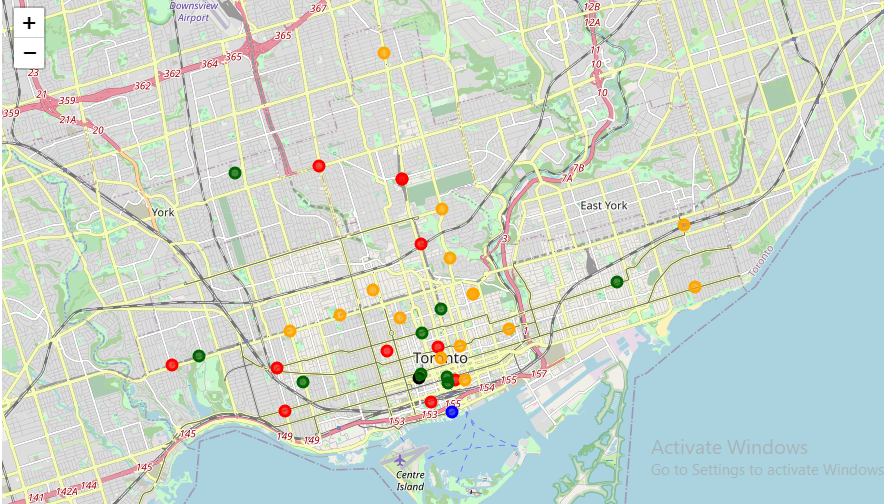

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("Toronto_Clustered.png")

## 12. Examine Clusters
### Cluster 0

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Downtown Toronto,0,Coffee Shop,Restaurant,Clothing Store,Thai Restaurant,Sushi Restaurant,Hotel,Bar,Speakeasy,Café,Event Space


### Cluster 1

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,West Toronto,1,Coffee Shop,Café,Bakery,Pizza Place,Bank,Latin American Restaurant,Pharmacy,Italian Restaurant,Dance Studio,Flower Shop
16,Downtown Toronto,1,Coffee Shop,Restaurant,Café,Hotel,Italian Restaurant,Gym,American Restaurant,Japanese Restaurant,Seafood Restaurant,Deli / Bodega
14,West Toronto,1,Bar,Vietnamese Restaurant,Park,Jazz Club,French Restaurant,Organic Grocery,Grocery Store,Dive Bar,Bus Stop,Bakery
25,West Toronto,1,Café,Tibetan Restaurant,Arts & Crafts Store,Pharmacy,Pizza Place,Coffee Shop,Bakery,Diner,Indian Restaurant,Restaurant
26,Central Toronto,1,Sushi Restaurant,Italian Restaurant,Coffee Shop,Trail,Convenience Store,Pharmacy,Pub,Park,Irish Pub,Japanese Restaurant
21,Central Toronto,1,Pizza Place,Bagel Shop,Burger Joint,Trail,Restaurant,Frozen Yogurt Shop,Bank,Italian Restaurant,Israeli Restaurant,Coffee Shop
20,Central Toronto,1,Sushi Restaurant,Italian Restaurant,Coffee Shop,Trail,Convenience Store,Pharmacy,Pub,Park,Irish Pub,Japanese Restaurant
6,Downtown Toronto,1,Coffee Shop,Clothing Store,Café,Hotel,Middle Eastern Restaurant,Plaza,Restaurant,Bubble Tea Shop,Sandwich Place,Diner
30,Downtown Toronto,1,Café,Coffee Shop,Bar,Mexican Restaurant,Bakery,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Taco Place,Pizza Place,Grocery Store
31,Central Toronto,1,Italian Restaurant,Coffee Shop,Spa,Boutique,Café,Cosmetics Shop,Sushi Restaurant,Yoga Studio,Beer Store,Butcher


### Cluster 2

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Chinese Restaurant,History Museum,Plaza,Bank,Pizza Place


### Cluster 3

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Downtown Toronto,3,Café,Park,Bookstore,Japanese Restaurant,Italian Restaurant,Yoga Studio,Dessert Shop,Bubble Tea Shop,Restaurant,Chinese Restaurant
33,Downtown Toronto,3,Park,Playground,Bike Trail,Japanese Restaurant,Yoga Studio,Donut Shop,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant
24,Central Toronto,3,Pizza Place,Park,Grocery Store,Ice Cream Shop,Indian Restaurant,Thai Restaurant,Coffee Shop,Gym,Bistro,Concert Hall
34,Downtown Toronto,3,Coffee Shop,Pizza Place,Café,Grocery Store,Playground,Beer Store,Restaurant,Bistro,Library,Diner
23,Central Toronto,3,Clothing Store,Coffee Shop,Restaurant,Thai Restaurant,Cosmetics Shop,Theater,Hotel,Diner,Plaza,Seafood Restaurant
29,Central Toronto,3,Gym,Convenience Store,Restaurant,Eastern European Restaurant,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
0,Downtown Toronto,3,Coffee Shop,Thai Restaurant,Auto Dealership,Indian Restaurant,Food Truck,Sushi Restaurant,Pub,Pool,Fast Food Restaurant,Beer Store
18,Central Toronto,3,Sushi Restaurant,Coffee Shop,Italian Restaurant,Bakery,Bank,Fast Food Restaurant,Asian Restaurant,Pub,Lingerie Store,Café
12,East Toronto,3,Coffee Shop,Bus Line,Mexican Restaurant,Doctor's Office,Restaurant,Sushi Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,Metro Station
9,West Toronto,3,Bar,Bakery,Coffee Shop,Café,Mexican Restaurant,Beer Store,Cocktail Bar,Sandwich Place,Grocery Store,Vegetarian / Vegan Restaurant


### Cluster 4

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Downtown Toronto,4,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,American Restaurant,Gym,Deli / Bodega,Salad Place,Seafood Restaurant
22,West Toronto,4,Pet Store,Pizza Place,Tennis Court,Pub,Pool,Convenience Store,Mexican Restaurant,Gym,Gym / Fitness Center,Concert Hall
17,East Toronto,4,Coffee Shop,Café,Clothing Store,Vegetarian / Vegan Restaurant,Cosmetics Shop,Japanese Restaurant,Yoga Studio,Theater,Restaurant,Shoe Store
15,East Toronto,4,Indian Restaurant,Grocery Store,Café,Burger Joint,Gastropub,Bar,Bistro,Snack Place,Shopping Plaza,Brewery
13,Downtown Toronto,4,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Japanese Restaurant,Asian Restaurant,Seafood Restaurant,Beer Bar,Tea Room
11,West Toronto,4,Bar,Café,Coffee Shop,Restaurant,Korean Restaurant,Bakery,Cocktail Bar,Boutique,Breakfast Spot,Dive Bar
1,Downtown Toronto,4,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Ice Cream Shop,Dessert Shop,Restaurant,Japanese Restaurant,Bubble Tea Shop,Vegetarian / Vegan Restaurant
19,Central Toronto,4,Coffee Shop,Bank,Argentinian Restaurant,Discount Store,Furniture / Home Store,Sandwich Place,Clothing Store,Bike Shop,Antique Shop,Paintball Field
36,Downtown Toronto,4,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Grocery Store,Gastropub,Hotel,Mediterranean Restaurant,Men's Store


## 13. Observations:
Most of the neighborhoods fall into Cluster 3 which are mostly business areas with cafe, restaurants, supermarkets etc. Cluster 0 & Cluster 2 has most common single area of coffee shop, Cluster 1 has one most common venue as restaurant,coffee shop, hotel, and lastly Cluster 4 has coffee shop as common venue.